The code in the "Package WeakL" and "Time-varying WeakL" paragraphs is the definition of the required functions for the Additive WeakL and Online WeakL models.

**Use case 2: Forecasting French electricity load** contains the code that generates the offline additive WeakL model.
- In **Validation offline**, the offline additive WeakL hyperparameters are tuned by grid search. The estimated effects for a given hour _h_ can be visualised with the *print_effect()* function
- **Generate additive WeakL** calculates the forecast of the offline model for each instant. One can visualise the forecast error for a given hour _h_ and the mean absolute error (MAE) for each hour computed over the test period.
- **Time-varying WeakL** generates the online adaptation of the offline WeakL error. Again, the hyperparameters are tuned by grid search in **Validation online**. 
- **Estimate uncertainty with stationary bootstrap** computes the confidence intervals of the RMSE and the MAPE in the same way as [[1]](#1)
## References
<a id="1">[1]</a>
Doumèche, N., Allioux, Y., Goude, Y. and Rubrichi, S., 2023. Human spatial dynamics for electricity demand forecasting: the case of france during the 2022 energy crisis. arXiv preprint arXiv:2309.16238.

In [1]:
# Allows to automatically switch from CPU to GPU
from datetime import timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def is_running_on_gpu():
  if torch.cuda.is_available():
    print("The algorithm is running on GPU.")
  else:
    print("The algorithm is not running on GPU.")

In [2]:
is_running_on_gpu()

The algorithm is running on GPU.


In [3]:
type_float64 = True

if type_float64:
  torch.set_default_dtype(torch.float64)
  np_dtype = np.float64
else:
  torch.set_default_dtype(torch.float32)
  np_dtype = np.float32

## Package WeakL

### Additive model

In [4]:
def normalize(dataset):
    data_min, data_max = np.min(dataset, axis=0), np.max(dataset, axis=0)
    center = (data_min+data_max)/2
    amplitude = data_max-data_min
    amplitude.replace(0, 1, inplace=True)
    return (dataset - center)/amplitude*2*torch.pi

def Sob_elementary(alpha, s, m):
    Sob_elem = torch.cat((torch.arange(-m, 0, device=device), torch.arange(1, m+1, device=device)))
    return alpha*(1+Sob_elem**(2*s))

def Sob_matrix(alpha_list, s_list, m_list):
    d = len(s_list)
    total_length = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    Sob_diag = torch.zeros(total_length, device=device)
    Sob_diag[0] = alpha_list[0]
    idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            Sob_diag[idx] = alpha_list[i + 1]
            idx += 1
        else:
            Sob_diag[idx:idx + 2*m_list[i]] = Sob_elementary(alpha_list[i + 1], s_list[i], m_list[i])
            idx += 2*m_list[i]
    return torch.diag(Sob_diag)


def mat_frequency(m_list, n):
    total_length = 1+sum(2 * m if m != "Linear" else 1 for m in m_list)
    frequencies = torch.zeros(total_length, device=device)
    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            frequencies[idx:idx + m] = torch.arange(-m, 0, device=device)
            frequencies[idx + m:idx + 2 * m] = torch.arange(1, m + 1, device=device)
            idx += 2 * m
    return torch.tile(frequencies, (n, 1))

def mat_linear(x_data, m_list, n):
    d = len(m_list)
    total_columns = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    mat = torch.zeros(n, total_columns, device=device)
    col_idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            mat[:, col_idx] = x_data[:, i] - 1
            col_idx += 1
        else:
            col_idx += 2 * m_list[i]
    return mat

def mat_data(x_data, m_list, n):
    d = len(m_list)
    total_columns = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    mat = torch.zeros(n, total_columns, device=device)

    col_idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            mat[:, col_idx] = x_data[:, i]
            col_idx += 1
        else:
            mat[:, col_idx:col_idx + 2 * m_list[i]] = torch.tile(x_data[:, i].view(-1, 1), (1, 2 * m_list[i]))
            col_idx += 2 * m_list[i]
    return mat


def phi_matrix(x_data, m_list):
    n = len(x_data)
    return torch.exp(-1j*torch.mul(mat_data(x_data, m_list, n),mat_frequency(m_list, n))/2)+mat_linear(x_data, m_list, n)

def regression_vector(x_data, y_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    covariance_XY = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@y_data
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, covariance_XY)

def estimation(fourier_coefs, z_data, m_list):
    fourier_coefs = fourier_coefs
    return phi_matrix(z_data, m_list)@fourier_coefs


def transform(df, m_list, fourier_vector, features):
    g_h = pd.DataFrame()
    g_h['Load'] = df['Load']
    g_h['Time']=df['Time']
    g_h['WeakL'] = torch.real(estimation(fourier_vector, torch.tensor(df[features].values, device=device), m_list)).view(-1).cpu().numpy()
    g_h["error"]=df["Load"]-g_h['WeakL']
    phi_mat = phi_matrix(torch.tensor(df[features].values, device=device), m_list)

    current = 1
    for j in range(len(features)):
        if m_list[j]=="Linear":
            linear_coeff = fourier_vector[current].cpu()
            g_h[features[j]] = linear_coeff*torch.tensor(df[features[j]].values).view(-1)
            current+= 1
        elif m_list[j] < 1:
            g_h[features[j]] = 0*1j
        else:
            partial_fourier = fourier_vector[current:current+2*m_list[j]]
            g_h[features[j]] = (phi_mat[:, current:current+2*m_list[j]]@partial_fourier).view(-1).cpu()
            current+= 2*m_list[j]
    return g_h



### Grid search WeakL

In [5]:
def calculate_total_length(m_list):
    return 1 + sum(2 * m if m != "Linear" else 1 for m in m_list)

def mat_frequency_h(m_list, n):
    total_length = calculate_total_length(m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            freq_range = torch.arange(1, m + 1, device=device)
            frequencies[idx:idx + m] = -freq_range.flip(0)
            frequencies[idx + m:idx + 2 * m] = freq_range
            idx += 2 * m
    return frequencies.unsqueeze(0).unsqueeze(0)

def mat_linear_h(x_data, m_list):
    batch_size, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, col_idx] = x_data[:, :, i] - 1
            col_idx += 1
        else:
            col_idx += 2 * m
    return mat

def mat_data_h(x_data, m_list):
    batch_size, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, col_idx] = x_data[:, :, i]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, i].unsqueeze(2).expand(batch_size, n, 2 * m)
            mat[:, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat

def phi_matrix_h(x_data, m_list):
    n = x_data.size(1)
    return torch.exp(-1j * mat_data_h(x_data, m_list) * mat_frequency_h(m_list, n) / 2) + mat_linear_h(x_data, m_list)


In [6]:
def cov_hourly_m(m_list, data_hourly):
    x_data, x_test, y_data, ground_truth = data_hourly

    phi_mat = phi_matrix_h(x_data, m_list)
    covariance_matrix_X = torch.bmm(phi_mat.transpose(1, 2).conj(), phi_mat)
    covariance_XY = torch.bmm(phi_mat.transpose(1, 2).conj(), y_data)
    phi_mat_z = phi_matrix_h(x_test, m_list)

    return covariance_matrix_X, covariance_XY, phi_mat_z, ground_truth

def regression_vector_grid(covariance_matrix_X, covariance_XY, M):
    return torch.linalg.solve(covariance_matrix_X+M, covariance_XY)

In [7]:
def half_hour_formatting(data, date, features_weakl):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features = features_weakl["features"]
    data_half_hourly = []

    for h in range(48):
        data_h = data[data['tod']==h]

        data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]
        df_train = data_h[(data_h['Time']>= begin_train)&(data_h['Time']<end_train)]
        df_test = data_h[(data_h['Time']>= end_train)&(data_h['Time']<end_test)]

        x_data = torch.tensor(df_train[features].values, device=device)
        x_test = torch.tensor(df_test[features].values, device=device)
        y_data = torch.tensor(df_train['Load'].values, device=device).view(-1,1)*(1+0*1j)
        ground_truth = torch.tensor(df_test['Load'].values, device=device)

        if type_float64:
          data_half_hourly.append([x_data, x_test, y_data, ground_truth])
        else:
          data_half_hourly.append([x_data.to(torch.float32), x_test.to(torch.float32), y_data.to(torch.complex64), ground_truth.to(torch.float32)])

    x_data = torch.stack([data_half_hourly[i][0] for i in range(48)])
    x_test = torch.stack([data_half_hourly[i][1] for i in range(48)])
    y_data = torch.stack([data_half_hourly[i][2] for i in range(48)])
    ground_truth = torch.stack([data_half_hourly[i][3] for i in range(48)])
    return x_data, x_test, y_data, ground_truth


In [8]:
def sob_effects(features_weakl, m_list, s_list, n):
    features_type = features_weakl["features_type"]
    n_param = len(features_type)+1
    select_dim = [[0 for i in range(n_param)] for i in range(n_param)]
    for i in range(n_param):
        select_dim[i][i] = 1
    sobolev_effects = []
    for i in range(n_param):
        sobolev_effects.append(Sob_matrix(select_dim[i], s_list, m_list))
    sobolev_effects = torch.stack(sobolev_effects)*n
    return sobolev_effects

In [9]:
def WeakL(data, hyperparameters, cov_hourly, M_stacked, criterion=""):
    fourier_vectors= torch.linalg.solve(cov_hourly[0]+M_stacked, cov_hourly[1])
    estimators = torch.matmul(cov_hourly[2], fourier_vectors).squeeze(-1)
    if criterion=="mape":
        perf_hourly = torch.mean(torch.abs(torch.real((estimators-cov_hourly[3])/cov_hourly[3])), dim=1)
        perf=torch.mean(perf_hourly)
    else:
        perf_hourly = torch.sqrt(torch.mean(torch.square(torch.real(estimators-cov_hourly[3])), dim=1))
        perf = torch.sqrt(torch.mean(torch.square(perf_hourly)))
        
    return perf, fourier_vectors, perf_hourly

In [10]:
def create_grid(features_weakl, n, grid_parameters):
    features_type = features_weakl["masked"]
    grid_size_m, grid_size_p, grid_step_p = grid_parameters["grid_size_m"], grid_parameters["grid_size_p"], grid_parameters["grid_step_p"]
    number_regression = 0

    m_range, alpha_const, alpha_grid_range, s_list = [], [[10**(-30)]], [], [] # Initializing power with the offset
    for feature_type in features_type:
        if feature_type == "masked":
            m_range.append(["Linear"]), alpha_const.append([10**(10)]), s_list.append("*")
        elif feature_type in ["bool", "linear"]:
            m_range.append(["Linear"]), alpha_const.append([10**(-30)]), s_list.append("*")
        elif feature_type[:11] == "categorical":
            n_categories = int(feature_type[11:])
            m_range.append([n_categories//2+n_categories%2]), alpha_const.append([10**(-30)]), s_list.append(0)
        elif feature_type == "regression":
            m_ini = grid_parameters["m_ini"]
            power_ini = -int(np.log(n)/np.log(10))
            m_possibilities = list(range(m_ini-grid_size_m, m_ini+grid_size_m+1))

            power_possibilities = np.arange(power_ini-grid_size_p*grid_step_p, power_ini+(grid_size_p+1)*grid_step_p, grid_step_p)
            m_range.append(m_possibilities), alpha_grid_range.append(10**power_possibilities), s_list.append(2)
            number_regression+=1
    grid_m = list(itertools.product(*m_range))

    grid_a = torch.cartesian_prod(*torch.tensor(np.array(alpha_grid_range, dtype=np_dtype), device=device)).view(-1, number_regression, 1, 1)
    alpha_const = torch.tensor(alpha_const, device=device).view(-1, 1, 1)

    regression_mask = [i+1 for i in range(len(features_type)) if features_type[i] == "regression"]
    non_reg_mask = [0]+[i+1 for i in range(len(features_type)) if features_type[i] != "regression"]
    return grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask


def grid_search_weakl(data, date, features_weakl, n, grid_parameters):
    grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask = create_grid(features_weakl, n, grid_parameters)
    len_grid_m, len_grid_a, counter = len(grid_m), len(grid_a), 0

    grid_a = grid_a.split(grid_parameters["batch_size"], dim=0)
    batch_number = len(grid_a)

    perf_min = torch.inf
    perf_h=[]
       
    m_list_opt, fourier_opt = [], []
    alpha_list_opt = torch.tensor([], device=device)
    
    data_hourly = half_hour_formatting(data, date, features_weakl)
    for m_list in grid_m:
      cov_hourly = cov_hourly_m(m_list, data_hourly)

      sobolev_effects = sob_effects(features_weakl, m_list, s_list, len(data_hourly[0][0]))
      mul1 = alpha_const*(sobolev_effects[non_reg_mask,:].unsqueeze(0))

      counter_batch =0
      print(str(counter*len_grid_a)+"/"+str(len_grid_m*len_grid_a))

      for grid_a_batch in grid_a:
        print("Batch: "+ str(counter_batch)+"/"+str(batch_number))
        counter_batch+=1

        mul2 = grid_a_batch*(sobolev_effects[regression_mask,:].unsqueeze(0))
        sobolev_matrices = torch.sum(mul1, dim=1, keepdim=True) + torch.sum(mul2, dim=1, keepdim=True)
        fourier_vectors= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_matrices, cov_hourly[1].unsqueeze(0))
        estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_vectors).squeeze(-1)
        errors = torch.real(cov_hourly[3].unsqueeze(0)-estimators)
        perf_hourly =  torch.sqrt(torch.mean(torch.square(errors), dim=2))
        perf_mean = torch.mean(perf_hourly, dim=1)
        min_perf_index = torch.argmin(perf_mean)

        if perf_mean[min_perf_index] < perf_min:
            m_list_opt, alpha_list_opt, perf_opt, fourier_opt, perf_h = m_list, grid_a_batch[min_perf_index], perf_mean[min_perf_index], fourier_vectors[min_perf_index], perf_hourly[min_perf_index]
            perf_min = perf_mean[min_perf_index]
      counter+=1
    alpha_opt = torch.zeros(len(regression_mask)+len(non_reg_mask), device=device)
    alpha_opt[regression_mask] = alpha_list_opt.view(-1)
    alpha_opt[non_reg_mask] = alpha_const.view(-1)
    return m_list_opt, alpha_opt, s_list, perf_opt, fourier_opt, perf_h

### Significativité des effets

In [11]:
def P_matrix(x_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1)))

def sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data):
    n = len(x_data)
    P = P_matrix(x_data, m_list, alpha_list, s_list)
    tr = torch.real(torch.trace(phi_matrix(x_data, m_list)@P))
    interpolation = torch.real(estimation(fourier_vector, x_data, m_list)).view(-1)
    err = torch.sum(torch.square(torch.abs(interpolation-y_data.view(-1)))).item()
    return 1/(n-tr)*err

def t_test(x_data, m_list, alpha_list, s_list, fourier_vector, y_data):
    t_stat = []
    P = P_matrix(x_data, m_list, alpha_list, s_list)
    mat = P@phi_matrix(x_data, m_list)@ torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@ torch.conj_physical(torch.transpose(P, 0,1))
    sigma = sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data).item()
    for i in range(len(fourier_vector)):
        t_stat.append(fourier_vector[i].item()/np.sqrt(mat[i,i].item()*sigma))
    return np.array(t_stat)

def print_t_test(test, features, m_list):
    print("--------------------------")
    print("T-tests")
    print("Offset: t-test = "+str(np.abs(test[0])), ", significant (5%) = "+ str(np.abs(test[0]) > 2))
    index = 0
    for i in range(len(features)):
        print('Feature '+ features[i])
        if m_list[i]=='Linear':
            index+=1
            print("Linear coefficient t-test = "+str(np.abs(test[index])), ", significant (5%) = "+ str(np.abs(test[index]) > 2))
        else:
            for j in range(2*m_list[i]):
                index+=1
                print("Fourier coefficient "+str(j)+" t-test = "+str(np.abs(test[index])), ", significant (5%) = "+ str(np.abs(test[index]) > 2))
    print("--------------------------")
    return

In [12]:
def print_effect(data, dates, features_weakl, hyperparameters, fourier_vectors, h):
    m_list, s_list, alpha_list = hyperparameters["m_list"], hyperparameters["s_list"], hyperparameters["alpha_list"]
    begin_train, end_train = dates["begin_train"], dates["end_train"]
    features = features_weakl['features']

    df_h = data[data['tod'] == h]
    df_h=df_h[features+['Load','Time']]
    df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]
    df_h = df_h[(df_h['Time']>= begin_train)&(df_h['Time']<end_train)]

    x_data = torch.tensor(df_h[features].values, device=device)
    y_data = torch.tensor(df_h['Load'].values, device=device).view(-1,1)*(1+0*1j)
    test=t_test(x_data, m_list, alpha_list, s_list, fourier_vectors[h], y_data)
    # print_t_test(test, features, m_list)

    g_h=transform(df_h, m_list, fourier_vectors[h], features)
    
    for feature in features:
        
        plt.figure()
        plt.title(feature)
        plt.scatter(df_h[feature], np.real(g_h[feature]), s=10, color='darkcyan')
        plt.show()
        




## Time-varying WeakL

In [13]:
def calculate_total_length(m_list):
    return 1 + sum(2 * m if m != "Linear" else 1 for m in m_list)

def mat_frequency_online(m_list):
    total_length = calculate_total_length(m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            freq_range = torch.arange(1, m + 1, device=device)
            frequencies[idx:idx + m] = -freq_range.flip(0)
            frequencies[idx + m:idx + 2 * m] = freq_range
            idx += 2 * m

    return frequencies.unsqueeze(0).unsqueeze(0).unsqueeze(0)

def mat_linear_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, -1] - 1
            col_idx += 1
        else:
            col_idx += 2 * m
    return mat

def mat_data_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    mat[:, :, :, 0] = 1

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, i]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, :, i].unsqueeze(-1).expand(batch_size, steps, n, 2 * m)
            mat[:, :, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat


def mat_time_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, -1]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, :, -1].unsqueeze(-1).expand(batch_size, steps, n, 2 * m)
            mat[:, :, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat

def phi_matrix_online(x_data, m_list):
    return  mat_data_online(x_data, m_list) *(torch.exp(-1j * mat_time_online(x_data, m_list)* mat_frequency_online(m_list) / 2) + mat_linear_online(x_data, m_list))


In [14]:
def cov_hourly_online(m_list, data_hourly):
    x_data, x_test, y_data, ground_truth = data_hourly
    phi_mat = phi_matrix_online(x_data, m_list)
    covariance_matrix_X = torch.matmul(phi_mat.transpose(2, 3).conj(), phi_mat)
    covariance_XY = torch.matmul(phi_mat.transpose(2, 3).conj(), y_data)
    phi_mat_z = phi_matrix_online(x_test, m_list)

    return covariance_matrix_X, covariance_XY, phi_mat_z, ground_truth

In [15]:
def half_hour_formatting_online(data, date, features_weakl, hyperparameters):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features = features_weakl["features"]
    fourier_vectors = hyperparameters["fourier_vectors"]
    m_list = hyperparameters["m_list"]
    window = hyperparameters["window"]
    data_hourly = []

    for h in range(48):
        x_online_list, x_test_list, y_online_list=[],[],[]

        data_h = data[data['tod']==h]

        data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]

        g_h=transform(data_h, m_list, fourier_vectors[h], features)
        g_h.loc[:,features]=normalize(g_h.loc[:,features]).loc[:,features]


        current_end_train = pd.to_datetime(end_train)
        current_end_test = current_end_train+timedelta(days=window)
        g_h['Time']=pd.to_datetime(g_h['Time'])
        
        
        learning_window = len(g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)])
        
        while current_end_train < pd.to_datetime(end_test):
            g_train = g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)]
            g_test = g_h[(g_h['Time']>=current_end_train)&(g_h['Time']<current_end_test)]
            
            x_online = torch.tensor(g_train[features].values, device=device)
            x_test_online = torch.tensor(g_test[features].values, device=device)


            if x_test_online.shape[0] != 0:
                y_online = torch.tensor(g_train['error'].values, device=device).view(-1,1)*(1+0*1j)

                if not type_float64:
                    x_online, x_test_online, y_online = x_online.to(torch.float32), x_test_online.to(torch.float32), y_online.to(torch.complex64)
            
                x_online_list.append(x_online[-learning_window:,:])
                x_test_list.append(x_test_online)
                y_online_list.append(y_online[-learning_window:,:])
                
                

            current_end_train = current_end_train+timedelta(days=window)
            current_end_test = min(current_end_test+timedelta(days=window), pd.to_datetime(end_test))

        g_test = g_h[(g_h['Time']>=end_train)&(g_h['Time']<end_test)]
        ground_truth_online = torch.tensor(g_test['error'].values, device=device)

        if not type_float64:
            ground_truth_online = ground_truth_online.to(torch.float32)
        data_hourly.append([torch.stack(x_online_list), torch.stack(x_test_list), torch.stack(y_online_list), ground_truth_online])
        

    x_data = torch.stack([data_hourly[i][0] for i in range(48)])
    x_test = torch.stack([data_hourly[i][1] for i in range(48)])
    y_data = torch.stack([data_hourly[i][2] for i in range(48)])
    ground_truth = torch.stack([data_hourly[i][3] for i in range(48)])
    
    return x_data, x_test, y_data, ground_truth

def formatting_online(data, date, features_weakl, hyperparameters, h):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features = features_weakl["features"]
    fourier_vectors = hyperparameters["fourier_vectors"]
    m_list = hyperparameters["m_list"]
    window = hyperparameters["window"]
    data_hourly = []

    x_online_list, x_test_list, y_online_list=[],[],[]

    data_h = data[data['tod']==h]

    data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]

    g_h=transform(data_h, m_list, fourier_vectors[h], features)
    g_h.loc[:,features]=normalize(g_h.loc[:,features]).loc[:,features]


    current_end_train = pd.to_datetime(end_train)
    current_end_test = current_end_train+timedelta(days=window)
    g_h['Time']=pd.to_datetime(g_h['Time'])
    
    learning_window = len(g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)])
    
    while current_end_train < pd.to_datetime(end_test):
        g_train = g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)]
        g_test = g_h[(g_h['Time']>=current_end_train)&(g_h['Time']<current_end_test)]
        
        x_online = torch.tensor(g_train[features].values, device=device)
        x_test_online = torch.tensor(g_test[features].values, device=device)


        if x_test_online.shape[0] != 0:
            y_online = torch.tensor(g_train['error'].values, device=device).view(-1,1)*(1+0*1j)

            if not type_float64:
                x_online, x_test_online, y_online = x_online.to(torch.float32), x_test_online.to(torch.float32), y_online.to(torch.complex64)
            
            x_online_list.append(x_online[-learning_window:,:])
            x_test_list.append(x_test_online)
            y_online_list.append(y_online[-learning_window:,:])
            

        current_end_train = current_end_train+timedelta(days=window)
        current_end_test = min(current_end_test+timedelta(days=window), pd.to_datetime(end_test))

    g_test = g_h[(g_h['Time']>=end_train)&(g_h['Time']<end_test)]
    ground_truth_online = torch.tensor(g_test['error'].values, device=device)

    if not type_float64:
        ground_truth_online = ground_truth_online.to(torch.float32)
    data_hourly.append([torch.stack(x_online_list), torch.stack(x_test_list), torch.stack(y_online_list), ground_truth_online])
        

    x_data = torch.stack([data_hourly[i][0] for i in range(1)])
    x_test = torch.stack([data_hourly[i][1] for i in range(1)])
    y_data = torch.stack([data_hourly[i][2] for i in range(1)])
    ground_truth = torch.stack([data_hourly[i][3] for i in range(1)])

    return x_data, x_test, y_data, ground_truth

In [16]:
def grid_search_online(data, date, features_weakl, n, grid_parameters, hyperparameters):
    grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask = create_grid(features_weakl, n, grid_parameters)
    len_grid_m, len_grid_a, counter = len(grid_m), len(grid_a), 0

    grid_a = grid_a.split(grid_parameters["batch_size"], dim=0)
    batch_number = len(grid_a)
    
    perf_min = torch.inf
    perf_h=[]
    m_list_opt, fourier_opt = [], []
    alpha_list_opt = torch.tensor([], device=device)

   
    data_hourly = half_hour_formatting_online(data, date, features_weakl, hyperparameters)
    for m_list in grid_m:
      cov_hourly = cov_hourly_online(m_list, data_hourly)


      sobolev_effects = sob_effects(features_weakl, m_list, s_list, len(data_hourly[0][0][0]))
      mul1 = alpha_const*(sobolev_effects[non_reg_mask,:].unsqueeze(0))

      print(str(counter*len_grid_a)+"/"+str(len_grid_m*len_grid_a))
      counter_batch = 0
      for grid_a_batch in grid_a:
        print("Batch: "+str(counter_batch)+"/"+str(batch_number))
        counter_batch+=1

        mul2 = grid_a_batch*(sobolev_effects[regression_mask,:].unsqueeze(0))
        sobolev_matrices = torch.sum(mul1, dim=1, keepdim=True) + torch.sum(mul2, dim=1, keepdim=True)
        sobolev_matrices = sobolev_matrices.unsqueeze(2)
       
        fourier_vectors= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_matrices, cov_hourly[1].unsqueeze(0))
        
        estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_vectors).squeeze(-1)
        errors = torch.real(cov_hourly[3].unsqueeze(0)-estimators.squeeze(-1))

        perf_hourly =  torch.sqrt(torch.mean(torch.square(errors), dim=2))
        perf_mean = torch.sqrt(torch.mean(torch.square(perf_hourly), dim=1))
            
        min_perf_index = torch.argmin(perf_mean)

        if perf_mean[min_perf_index] < perf_min:
              m_list_opt, alpha_list_opt, perf_opt, fourier_opt, perf_h = m_list, grid_a_batch[min_perf_index], perf_mean[min_perf_index], fourier_vectors[min_perf_index], perf_hourly[min_perf_index]
              perf_min = perf_mean[min_perf_index]
      counter+=1
      
    alpha_opt = torch.zeros(len(regression_mask)+len(non_reg_mask), device=device)
    alpha_opt[regression_mask] = alpha_list_opt.view(-1)
    alpha_opt[non_reg_mask] = alpha_const.view(-1)
  
    return m_list_opt, alpha_opt, s_list, perf_opt, fourier_opt, perf_h



# Use case 2: Forecasting the French electricity load

One can set the variable HOLIDAYS to False to exclude holidays or to True to include them.

In [17]:
df = pd.read_csv('dataset_national.csv')
HOLIDAYS = False

if HOLIDAYS: 
    columns = ["date", "tod", 
            "Load", "Load_d1", "Load_d7",
            "temperature_smooth_950", "temperature", "temperature_max_smooth_990", 'temperature_min_smooth_950',
                'toy', 'day_type_week', "day_type_jf"]
    data = df[columns].copy()
    data['day_type_week']=np.float64(data.loc[:,'day_type_week'])
    data.rename(columns={'date':'Time'}, inplace=True)
    n = len(data['Time'])
    data['time'] = [i/n*np.pi for i in range(n)]
else: 
    columns_holidays = ["date", "tod", "period_christmas", 'period_summer',
           "Load", "Load_d1", "Load_d7",
           "temperature_smooth_950", "temperature", "temperature_max_smooth_990", 'temperature_min_smooth_950',
            'toy', 'day_type_week', "day_type_jf"]
    data = df[columns_holidays].copy()
    data.rename(columns={'date':'Time'}, inplace=True)
    data['day_type_week']=np.float64(df.loc[:,'day_type_week'])

    holidays = np.where(data['day_type_jf'] == 1)[0]
    holidays_24h_window = np.concatenate([holidays - 48, holidays, holidays + 48])

    # Ensure indices are within bounds
    holidays_24h_window = np.clip(holidays_24h_window, 0, len(data) - 1)

    # Identifying outliers
    outliers = np.unique(np.concatenate([
        holidays_24h_window,
        np.where(data['period_summer'] != 0)[0],
        np.where(data['period_christmas'] != 0)[0]
    ]))

    data = data.drop(outliers)
    n = len(data['Time'])
    data['time'] = [i/n*np.pi for i in range(n)]

## WeakL

In [18]:
features_weakl = {"features": ["Load_d1", 
           "temperature_smooth_950", "temperature", "temperature_max_smooth_990", 'temperature_min_smooth_950',
            'toy',  'day_type_week', 'day_type_jf', 'Load_d7','time'],
            "features_type":['linear','regression','regression','regression','regression','regression','categorical7','linear','linear','linear']}

features_weakl["masked"] = features_weakl["features_type"].copy()

### Validation

In [19]:
dates_val = {"begin_train": "2013-01-08 00:00:00+00:00",
"end_train": "2021-09-01 00:00:00+00:00",
"end_test": "2022-09-01 00:00:00+00:00"}


In [20]:
grid_parameters ={
    "grid_size_m": 0,
    "m_ini": 20,
    "grid_size_p": 2,
    "grid_step_p": 3.,
    "batch_size": 1*10**2
} 

n = len(data[(data['Time']>= dates_val["begin_train"])&(data['Time']<dates_val["end_train"])])//48

m_list, alpha_list, s_list, rmse, fourier_vectors, rmse_h = grid_search_weakl(data, dates_val, features_weakl, n, grid_parameters)

hyperparameters = {"m_list": m_list,
                   "s_list": s_list,
                   "alpha_list": alpha_list,
                   "fourier_vectors": fourier_vectors}

print(hyperparameters["m_list"])
print(hyperparameters["alpha_list"])
print(hyperparameters["s_list"])
print("Validation RMSE = "+str(rmse.cpu().numpy())) #1m15s

0/3125
Batch: 0/32
Batch: 1/32
Batch: 2/32
Batch: 3/32
Batch: 4/32
Batch: 5/32
Batch: 6/32
Batch: 7/32
Batch: 8/32
Batch: 9/32
Batch: 10/32
Batch: 11/32
Batch: 12/32
Batch: 13/32
Batch: 14/32
Batch: 15/32
Batch: 16/32
Batch: 17/32
Batch: 18/32
Batch: 19/32
Batch: 20/32
Batch: 21/32
Batch: 22/32
Batch: 23/32
Batch: 24/32
Batch: 25/32
Batch: 26/32
Batch: 27/32
Batch: 28/32
Batch: 29/32
Batch: 30/32
Batch: 31/32
('Linear', 20, 20, 20, 20, 20, 4, 'Linear', 'Linear', 'Linear')
tensor([1.0000e-30, 1.0000e-30, 1.0000e-06, 1.0000e-06, 1.0000e-03, 1.0000e-06,
        1.0000e-06, 1.0000e-30, 1.0000e-30, 1.0000e-30, 1.0000e-30],
       device='cuda:0')
['*', 2, 2, 2, 2, 2, 0, '*', '*', '*']
Validation RMSE = 893.0361988202391


/tmp/tmp-d07784/ipykernel_39299/3241829723.py:20: RuntimeWarning: invalid value encountered in scalar divide
  t_stat.append(fourier_vector[i].item()/np.sqrt(mat[i,i].item()*sigma))


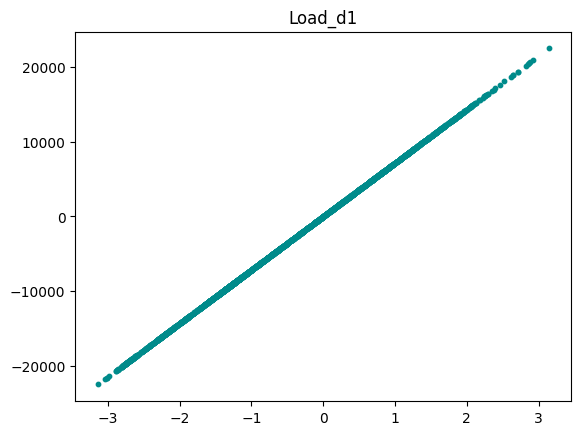

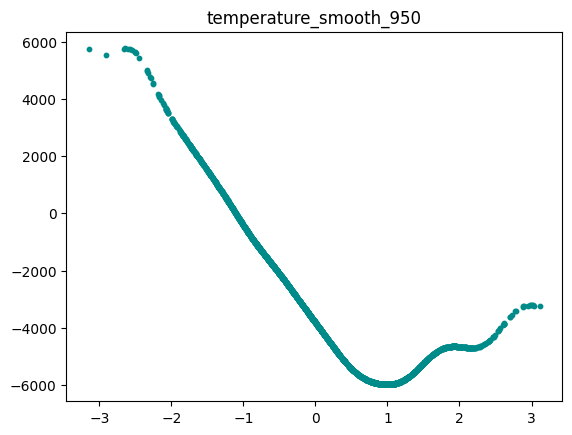

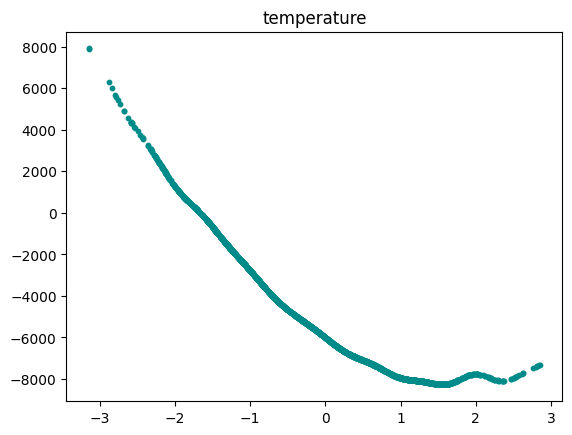

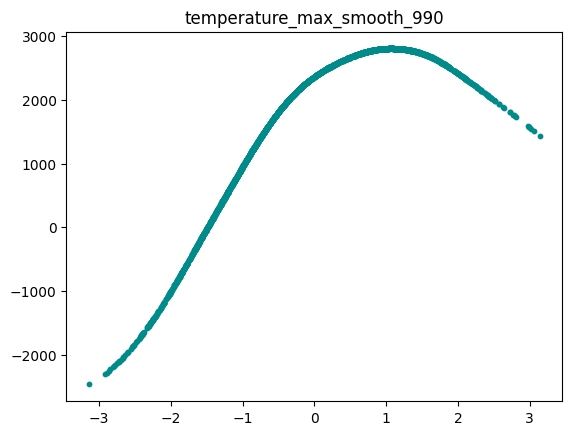

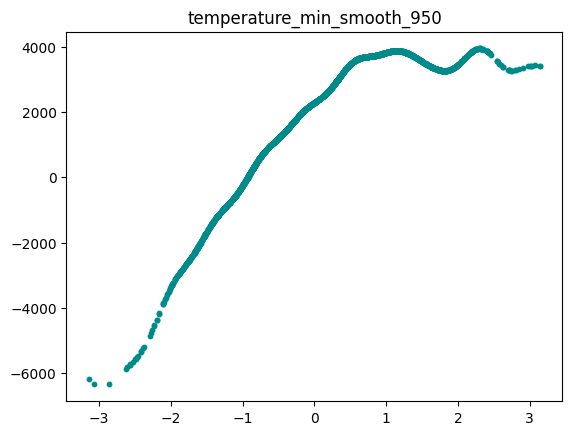

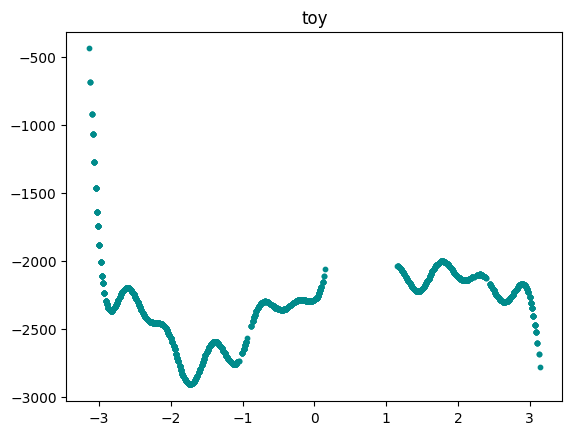

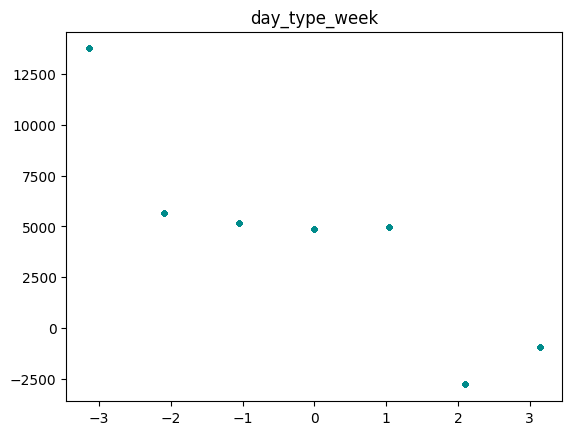

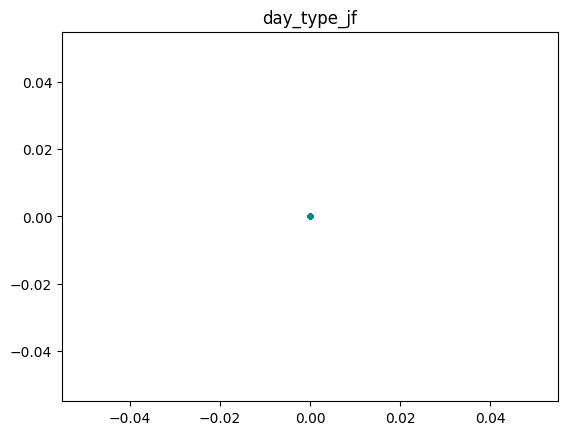

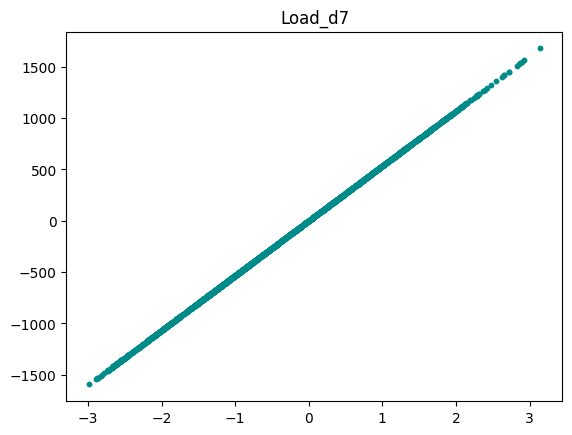

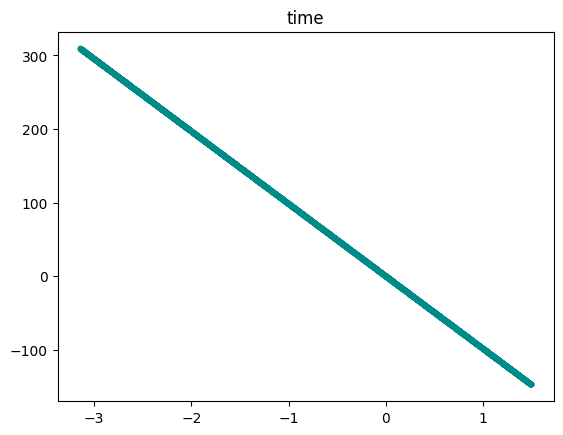

In [21]:
print_effect(data,dates_val,features_weakl, hyperparameters, fourier_vectors,20)

### Test

In [22]:

dates_test = {"begin_train": "2013-01-08 00:00:00+00:00",
"end_train": "2022-09-01 00:00:00+00:00",
"end_test": "2023-02-28 00:00:00+00:00"}


In [23]:
data_hourly = half_hour_formatting(data, dates_test, features_weakl)
cov_hourly = cov_hourly_m(m_list, data_hourly)
sobolev_matrix = Sob_matrix(alpha_list, s_list, m_list)*len(data_hourly[0][0])
M_stacked = torch.stack([sobolev_matrix for i in range(48)])

# criterion = "mape"
criterion = "rmse"

perf_test, fourier_vectors_test, perf_h_test = WeakL(data, hyperparameters, cov_hourly, M_stacked, criterion=criterion)
if criterion == "rmse":
    print("The RMSE offline is "+ str(perf_test.cpu().numpy()))
if criterion == "mape":
    print("The MAPE offline is "+ str(perf_test.cpu().numpy()))

The RMSE offline is 1588.4509479968542


In [24]:
hyperparameters_test = {"m_list": m_list,
                   "s_list": s_list,
                   "alpha_list": alpha_list,
                   "fourier_vectors": fourier_vectors_test}

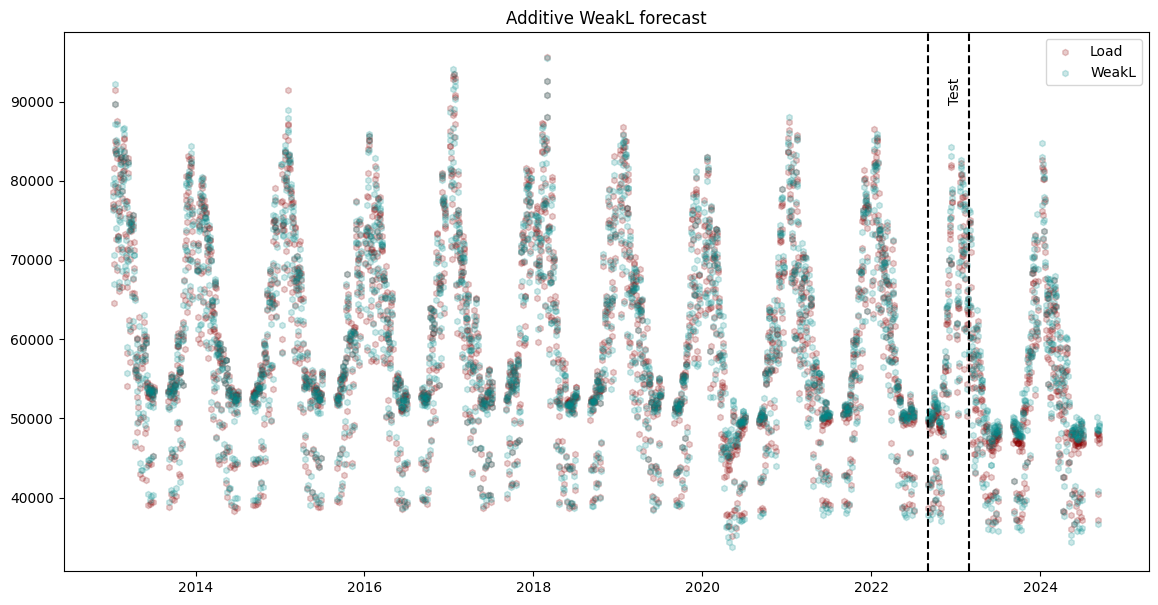

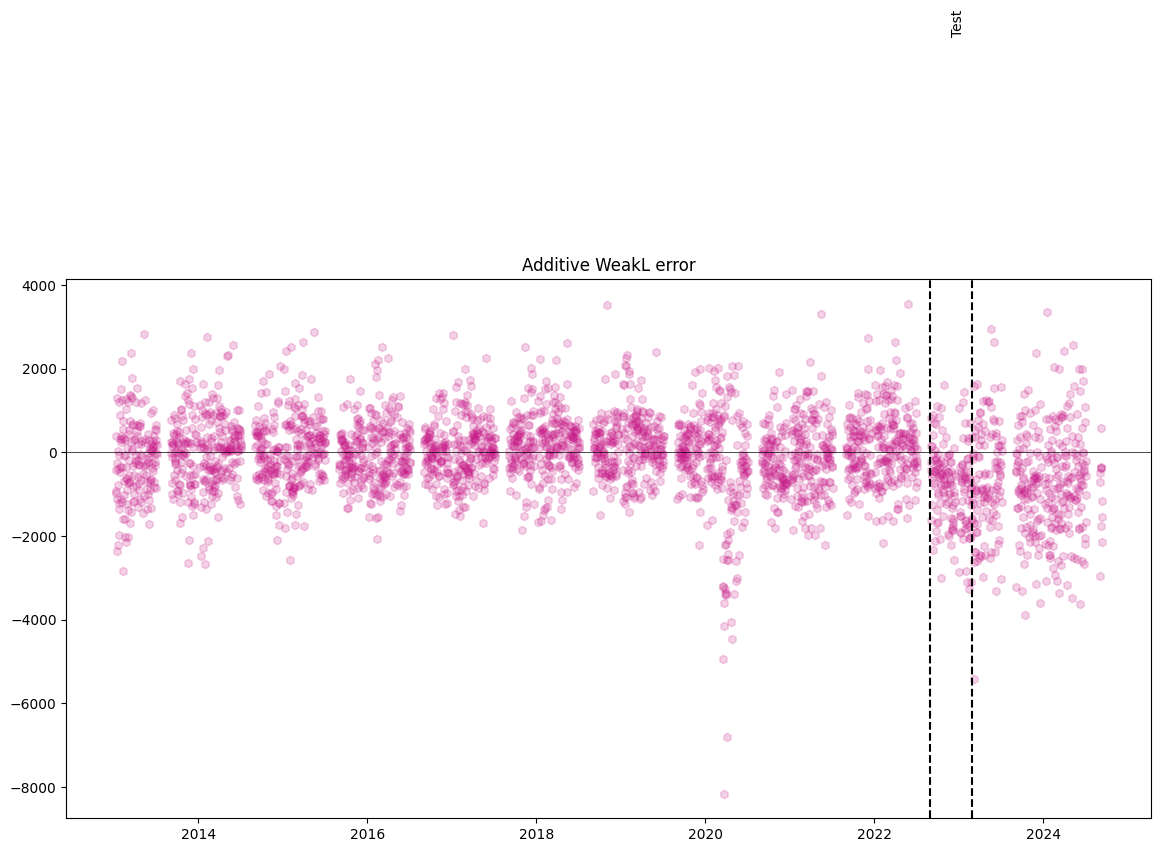

In [25]:
h=20
data_h = data[data['tod']==h]
data_h.loc[:,features_weakl["features"]]=normalize(data_h.loc[:,features_weakl["features"]]).loc[:,features_weakl["features"]]
estimate = transform(data_h, m_list, fourier_vectors_test[h], features_weakl["features"])

plt.figure(figsize=(14,7))
plt.title("Additive WeakL forecast")
# plt.plot(pd.to_datetime(estimate["Time"]), estimate["Load"], label="Load", linestyle="solid", color='navy', linewidth=2, alpha=1)
# plt.plot(pd.to_datetime(estimate["Time"]), estimate["WeakL"], label="Weakl", linestyle = (0,(1,1)), linewidth=1, color='crimson', alpha=0.7)
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["Load"], label="Load", marker="h", color="darkred", s=20, alpha=0.2)
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["WeakL"], label="WeakL", marker="h", color="darkcyan", s=20, alpha=0.2)
plt.axvline(x=pd.to_datetime(dates_test["end_train"]), linestyle='--', color='black')
plt.axvline(x=pd.to_datetime(dates_test["end_test"]), linestyle='--', color='black')
plt.text(pd.to_datetime(dates_test["end_train"])+timedelta(days=(pd.to_datetime(dates_test["end_test"])-pd.to_datetime(dates_test["end_train"])).days//2),90000, 'Test', rotation=90)
plt.legend()
plt.show()
plt.figure(figsize=(14,7))
plt.title("Additive WeakL error")
# plt.plot(pd.to_datetime(estimate["Time"]), estimate["error"], color='darkmagenta', linewidth=0.5)
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["error"], color='mediumvioletred', marker="h", alpha=0.2)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=pd.to_datetime(dates_test["end_train"]), linestyle='--', color='black')
plt.axvline(x=pd.to_datetime(dates_test["end_test"]), linestyle='--', color='black')
plt.text(pd.to_datetime(dates_test["end_train"])+timedelta(days=(pd.to_datetime(dates_test["end_test"])-pd.to_datetime(dates_test["end_train"])).days//2),10000, 'Test', rotation=90)
plt.show()


## Time-varying WeakL

### Validation

Time must be the last features of the WeakL for the time-varying WeakL to work.

In [26]:
hyperparameters_offline = hyperparameters_test.copy()
hyperparameters_offline["window"] = 1

dates_val_online = {"begin_train": "2018-02-01 00:00:00+00:00",
"end_train": "2020-04-01 00:00:00+00:00",
"end_test": "2020-06-01 00:00:00+00:00"}

n = len(data[(data['Time']>= dates_val_online["begin_train"])&(data['Time']<dates_val_online["end_train"])])//48

import copy
features_weakl_online = copy.deepcopy(features_weakl)

masked = [0,1,2,3,4,5,7,8]
masked = [0,1,2,3,5,7,8]
features_weakl_online["features_type"][-1]="regression"
features_weakl_online["masked"][-1]="regression"
features_weakl_online["features_type"][6]="regression"
features_weakl_online["masked"][6]="regression"
features_weakl_online["features_type"][4]="regression"
features_weakl_online["masked"][4]="regression"
for idx in masked:
    features_weakl_online["features_type"][idx]="linear"
    features_weakl_online["masked"][idx]="masked"

grid_parameters ={
    "grid_size_m": 0,
    "m_ini": 5,
    "grid_size_p": 4,
    "grid_step_p": 1.,
    "batch_size": 2*10**1
}

In [27]:
m_online, alpha_online, s_online, rmse_online_val, fourier_online_val, rmse_list_opt = grid_search_online(data, dates_val_online, features_weakl_online, n, grid_parameters, hyperparameters_offline)

/tmp/tmp-d07784/ipykernel_39299/1527520574.py:44: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  mat[:, :, :, col_idx] = x_data[:, :, :, i]


0/729
Batch: 0/37
Batch: 1/37
Batch: 2/37
Batch: 3/37
Batch: 4/37
Batch: 5/37
Batch: 6/37
Batch: 7/37
Batch: 8/37
Batch: 9/37
Batch: 10/37
Batch: 11/37
Batch: 12/37
Batch: 13/37
Batch: 14/37
Batch: 15/37
Batch: 16/37
Batch: 17/37
Batch: 18/37
Batch: 19/37
Batch: 20/37
Batch: 21/37
Batch: 22/37
Batch: 23/37
Batch: 24/37
Batch: 25/37
Batch: 26/37
Batch: 27/37
Batch: 28/37
Batch: 29/37
Batch: 30/37
Batch: 31/37
Batch: 32/37
Batch: 33/37
Batch: 34/37
Batch: 35/37
Batch: 36/37


In [28]:
print("m online = ", m_online)
print("alpha online = ", alpha_online)
print("s online = ", s_online)
print("Validation RMSE = ", rmse_online_val.cpu().numpy())


m online =  ('Linear', 'Linear', 'Linear', 'Linear', 5, 'Linear', 5, 'Linear', 'Linear', 5)
alpha online =  tensor([1.0000e-30, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e+10, 1.0000e-06,
        1.0000e+10, 1.0000e-05, 1.0000e+10, 1.0000e+10, 1.0000e-06],
       device='cuda:0')
s online =  ['*', '*', '*', '*', 2, '*', 2, '*', '*', 2]
Validation RMSE =  932.2653865693896


### Test

In [29]:
dates_test_online = {"begin_train": "2020-07-01 00:00:00+00:00", 
"end_train": "2022-09-01 00:00:00+00:00",
"end_test": "2023-02-28 00:00:00+00:00"}

mask = ((data['Time']>=dates_test_online["end_train"])&(data['Time']<dates_test_online["end_test"]))
estimators=np.zeros((1,48,mask.sum()//48), dtype=np.complex64)

for h in range(48):
    data_h = data[data['tod']==h]
    data_hourly = formatting_online(data_h, dates_test_online, features_weakl_online, hyperparameters_offline,h)
    cov_hourly = cov_hourly_online(m_online, data_hourly)
    sobolev_effects = sob_effects(features_weakl_online, m_online, s_online, len(data_hourly[0][0][0]))
    sobolev_effects_online = (sobolev_effects*alpha_online.unsqueeze(-1).unsqueeze(-1)).sum(dim=0)
    fourier_online_test= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_effects_online, cov_hourly[1].unsqueeze(0))
    estimators[0,h,:] = (torch.matmul(cov_hourly[2].unsqueeze(0), fourier_online_test).squeeze(-1)[0, 0, :, 0]).cpu().numpy()

In [30]:
test = ((data['Time']>=dates_test_online["end_train"])&(data['Time']<dates_test_online["end_test"]))

ground_truth = data['Load'].values
estimate_online = np.zeros(len(data['Load']))
estimate_offline=estimate_online.copy()

for h in range(48):
  mask = (data['tod']==h)
  data_h=data[mask]
  data_h.loc[:,features_weakl['features']]=normalize(data_h.loc[:,features_weakl["features"]]).loc[:,features_weakl["features"]]
  estimate_online[mask]=transform(data_h, m_list, fourier_vectors_test[h], features_weakl["features"]).loc[:,'WeakL']
  estimate_offline[mask]=estimate_online[mask].copy()
  online_ajust = estimate_online.copy()
  online_ajust[test&mask]+=np.real(estimators[0,h,:])
  estimate_online=online_ajust

rmse_offline = np.sqrt(np.mean(np.square(ground_truth[test]-estimate_offline[test])))
mape_offline = np.mean(np.abs((ground_truth[test]-estimate_offline[test])/ground_truth[test]))
rmse_online = np.sqrt(np.mean(np.square(ground_truth[test]-estimate_online[test])))
mape_online = np.mean(np.abs((ground_truth[test]-estimate_online[test])/ground_truth[test]))

In [31]:
print("Offline:\n ""RMSE:  ",rmse_offline,"\n","MAPE: ",mape_offline)
print("Online:\n ""RMSE:  ",rmse_online,"\n","MAPE: ",mape_online)

Offline:
 RMSE:   1588.4509479968544 
 MAPE:  0.023838736899234176
Online:
 RMSE:   885.7916890151479 
 MAPE:  0.011969469615252774


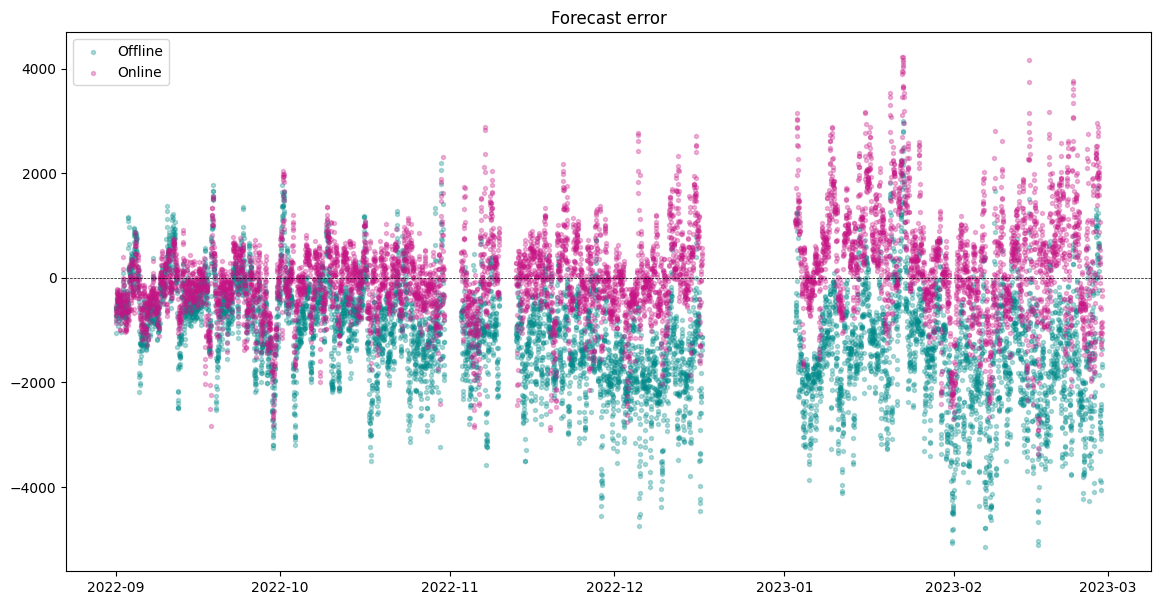

In [32]:
plt.figure(figsize=(14,7))
plt.title("Forecast error")
plt.scatter(pd.to_datetime(data["Time"])[test], ground_truth[test]-estimate_offline[test], label="Offline", marker="h", color='darkcyan',s=10, alpha=0.3)
plt.scatter(pd.to_datetime(data["Time"])[test], ground_truth[test]-estimate_online[test], label="Online", marker="h",  color='mediumvioletred',s=10, alpha=0.3)
plt.axhline(y=0, linestyle="--", color='black', linewidth=0.5)
plt.legend()
plt.show()

## Estimate uncertainty with stationary bootstrap

In [33]:
from arch.bootstrap import StationaryBootstrap


res_offline = ground_truth[test]-estimate_offline[test]
res = ground_truth[test]-estimate_online[test]

res_offline_relative = (ground_truth[test]-estimate_offline[test])/ground_truth[test]
res_relative = (ground_truth[test]-estimate_online[test])/ground_truth[test]

bs_offline = StationaryBootstrap(48,res_offline, seed=948)
bs_online = StationaryBootstrap(48,res, seed=948)

bs_offline_relative = StationaryBootstrap(48, res_offline_relative)
bs_online_relative = StationaryBootstrap(48,res_relative)

rmse_offline_boot = np.array([np.sqrt(np.mean(sample[0][0]**2)) for sample in bs_offline.bootstrap(1000)])
rmse_offline_mean = np.mean(rmse_offline_boot)
rmse_offline_sd = np.std(rmse_offline_boot)

rmse_online_boot = np.array([np.sqrt(np.mean(sample[0][0]**2)) for sample in bs_online.bootstrap(1000)])
rmse_online_mean = np.mean(rmse_online_boot)
rmse_online_sd = np.std(rmse_online_boot)

mape_offline_boot = np.array([np.mean(np.abs(sample[0][0])) for sample in bs_offline_relative.bootstrap(1000)])
mape_offline_mean = np.mean(mape_offline_boot)
mape_offline_sd = np.std(mape_offline_boot)

mape_online_boot = np.array([np.mean(np.abs(sample[0][0])) for sample in bs_online_relative.bootstrap(1000)])
mape_online_mean = np.mean(mape_online_boot)
mape_online_sd = np.std(mape_online_boot)

print("            "+"RMSE"+"        "+"MAPE")
print("Offline:  "+f"{rmse_offline_mean:.3g}"+"-+"+f"{rmse_offline_sd:.2g}"+"    "+f"{mape_offline_mean:.3g}"+"-+"+f"{mape_offline_sd:.2g}")
print("Online:  "+f"{rmse_online_mean:.3g}"+"-+"+f"{rmse_online_sd:.2g}"+"    "+f"{mape_online_mean:.3g}"+"-+"+f"{mape_online_sd:.2g}")


            RMSE        MAPE
Offline:  1.59e+03-+62    0.0238-+0.00089
Online:  884-+45    0.012-+0.00055
